In [11]:
import numpy as np
import scipy as sp
import scipy.stats as st
import sys,json,os
sys.path.append('../..')
import matplotlib.pyplot as plt
import Project.profiles as pp
import Project.new_profiles as pnp
import Project.plot_assist as pa
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

In [12]:
def v2kpc(r,vc):
    try:
        lowi = np.where(r == np.max(r[r <= 2]))[0][0]
    except:
        if r[0] > 2:
            r = np.array([ri for ri in [0,*r]])
            vc = np.array([vi for vi in [0,*vc]])
            lowi = np.where(r == np.max(r[r <= 2]))[0][0]
    try:
        higi = np.where(r == np.min(r[r >= 2]))[0][0]
    except:
        if r[-1] < 2:
            return vc[-1]
        else:
            print ('some other problem')
    rlow,vlow = r[lowi],vc[lowi]
    rhig,vhig = r[higi],vc[higi]
    if rlow == 2:
        return vlow
    elif rhig == 2:
        return vhig
    else:
        m = (vhig-vlow)/(rhig-rlow)
        c = vlow - m*rlow
        v2 = m*2. + c
        return v2
    
def get_diversity(galfile,model,gald):
    vmax,v2,lm,lms,lsig,lz = [],[],[],[],[],[]
    for lm_i in range(15):
        for rn_i in range(15):
            for i in range(50):
                gal = '%i_%i_%s_gal_%i'%(lm_i,rn_i,model,i)
                data = np.loadtxt(galfile+'/%s.dat'%gal)
                vmaxi = np.max(data[:,1])
                v2i = v2kpc(data[:,0],data[:,1])
                vmax.append(vmaxi)
                v2.append(v2i)
                lm.append(gald[gal]['original']['lm'])
                lms.append(gald[gal]['original']['lmstar'])
                lsig.append(gald[gal]['original']['lsig'])
                lz.append(gald[gal]['core_fit']['lnZ']-gald[gal]['cusp_fit']['lnZ'])
    return np.array(vmax),np.array(v2),np.array(lm),np.array(lms),np.array(lsig),np.array(lz)

In [146]:
sparcd = json.load(open('../../obs_RC_v4/Output/result_dicts/sparc_fit_dict.json','r'))
bry_2 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_2sig_dict.json','r'))
bry_1 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_1sig_dict.json','r'))
bry_p5 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_p5sig_dict.json','r'))

In [163]:
v2_R = []
vl_R = []
vm_R = []
gals = []
for gal in sparcd['lcdm']:
    data = np.loadtxt('../../Accessory/RotCurvs/%s_rotmod.dat'%gal)
    r = data[:,0]
    vc = data[:,1]
    v2_R.append(v2kpc(r,vc))
    vl_R.append(vc[-1])
    vm_R.append(np.max(np.array(vc)))
    gals.append(gal)

In [15]:
vmax_2n,v2_2n,lm_2n,lms_2n,lsig_2n,lz_2n = get_diversity('../../sim_RC_12/Output/Mock_gals/Bry_2sig_gals/','N',bry_2)
vmax_2c,v2_2c,lm_2c,lms_2c,lsig_2c,lz_2c = get_diversity('../../sim_RC_12/Output/Mock_gals/Bry_2sig_gals/','S',bry_2)

In [16]:
vmax_1n,v2_1n,lm_1n,lms_1n,lsig_1n,lz_1n = get_diversity('../../sim_RC_12/Output/Mock_gals/Bry_1sig_gals/','N',bry_1)
vmax_1c,v2_1c,lm_1c,lms_1c,lsig_1c,lz_1c = get_diversity('../../sim_RC_12/Output/Mock_gals/Bry_1sig_gals/','S',bry_1)

In [148]:
vmax_p5n,v2_p5n,lm_p5n,lms_p5n,lsig_p5n,lz_p5n = get_diversity('../../sim_RC_12/Output/Mock_gals/Bry_p5sig_gals/','N',bry_p5)
vmax_p5c,v2_p5c,lm_p5c,lms_p5c,lsig_p5c,lz_p5c = get_diversity('../../sim_RC_12/Output/Mock_gals/Bry_p5sig_gals/','S',bry_p5)

In [17]:
def plot_diversity(vmax,v2,cmap_array,cmap = plt.get_cmap('plasma'),
                   cblabel = '$\mathrm{log}\,(M_{200}\,/\,\mathrm{M_{\odot}}}$)',v_min=None,v_max = None):
    fig,axs = plt.subplots(1,2,figsize = (16,6),gridspec_kw = {'wspace':0.2})
    ax1,ax2 = axs
    ax1.scatter(vmax[0],v2[0], c = cmap_array[0], cmap = cmap, alpha = 1,vmin = v_min,vmax = v_max)
    sc = ax2.scatter(vmax[1],v2[1], c = cmap_array[1], cmap = cmap, alpha = 1,vmin = v_min,vmax=v_max)
    cb = fig.colorbar(sc, ax=axs.ravel().tolist(),pad = 0.02)
    cb.set_label(label = cblabel,size = 13)

    clr = plt.get_cmap('viridis')(0.5)
    ticks = [10,50,100,200,500]
    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.scatter(vm_R,v2_R,color = clr,marker = 's',lw = 1.5,facecolor = 'none')
        ax.set_xlim(9e0,800)
        ax.set_ylim(9e0,800)
        ax.plot(ax.get_xlim(),ax.get_ylim(),c = 'k',lw = 2)
        ax.tick_params(direction = 'in',which = 'both',width = 1,length = 2,top=True,right=True)
        ax.tick_params(which = 'major',length = 4,width = 1.4)
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticks)
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)
        ax.set_xlabel('$V_{\mathrm{max}}$ $(\mathrm{km\,s^{-1})}$',size = 13)
        ax.set_ylabel('$V_c\,(2\,\mathrm{kpc})$ $(\mathrm{km\,s^{-1}})$',size = 13)
    return fig,ax1,ax2

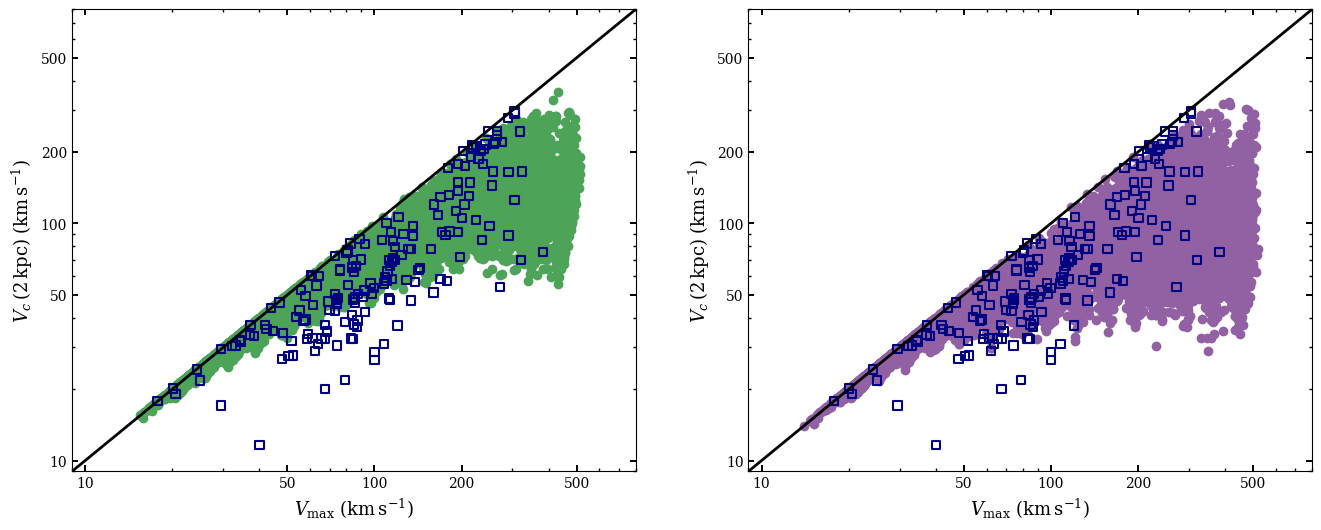

In [27]:
fig,axs = plt.subplots(1,2,figsize = (16,6),gridspec_kw = {'wspace':0.2})
ax1,ax2 = axs
ax1.scatter(vmax_1n,v2_1n, color = pa.green, alpha = 1)
ax2.scatter(vmax_1c,v2_1c, color = pa.purple, alpha = 1)

ticks = [10,50,100,200,500]
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(vm_R,v2_R,color = 'navy',marker = 's',lw = 1.5,facecolor = 'none')
    ax.set_xlim(9e0,800)
    ax.set_ylim(9e0,800)
    ax.plot(ax.get_xlim(),ax.get_ylim(),c = 'k',lw = 2)
    ax.tick_params(direction = 'in',which = 'both',width = 1,length = 2,top=True,right=True)
    ax.tick_params(which = 'major',length = 4,width = 1.4)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_xlabel('$V_{\mathrm{max}}$ $(\mathrm{km\,s^{-1})}$',size = 13)
    ax.set_ylabel('$V_c\,(2\,\mathrm{kpc})$ $(\mathrm{km\,s^{-1}})$',size = 13)

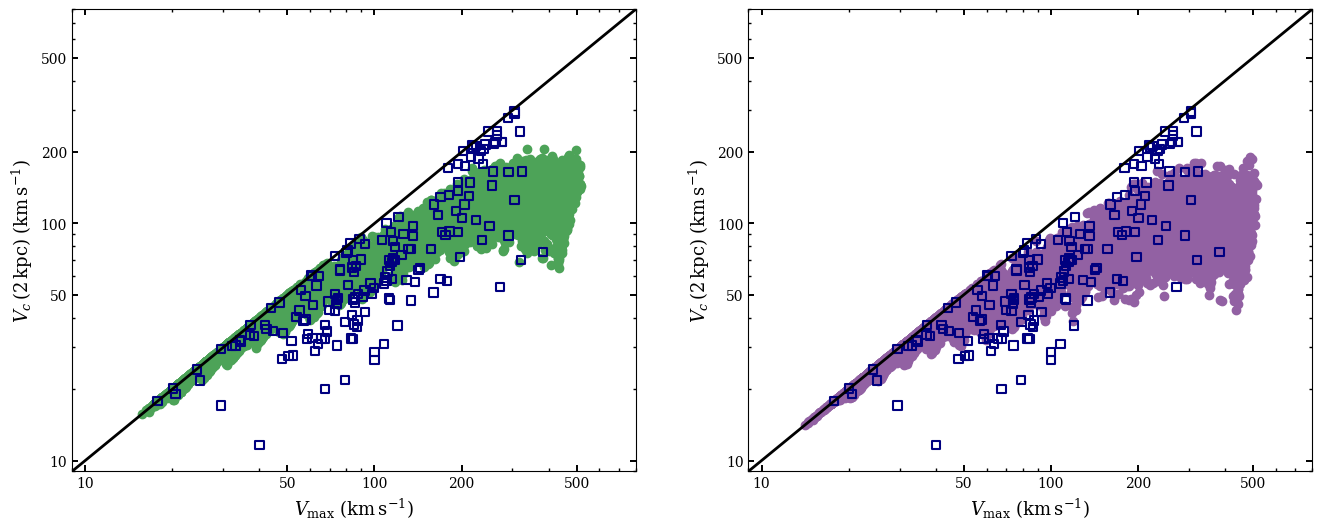

In [29]:
fig,axs = plt.subplots(1,2,figsize = (16,6),gridspec_kw = {'wspace':0.2})
ax1,ax2 = axs
ax1.scatter(vmax_p5n,v2_p5n, color = pa.green, alpha = 1)
ax2.scatter(vmax_p5c,v2_p5c, color = pa.purple, alpha = 1)

ticks = [10,50,100,200,500]
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(vm_R,v2_R,color = 'navy',marker = 's',lw = 1.5,facecolor = 'none')
    ax.set_xlim(9e0,800)
    ax.set_ylim(9e0,800)
    ax.plot(ax.get_xlim(),ax.get_ylim(),c = 'k',lw = 2)
    ax.tick_params(direction = 'in',which = 'both',width = 1,length = 2,top=True,right=True)
    ax.tick_params(which = 'major',length = 4,width = 1.4)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_xlabel('$V_{\mathrm{max}}$ $(\mathrm{km\,s^{-1})}$',size = 13)
    ax.set_ylabel('$V_c\,(2\,\mathrm{kpc})$ $(\mathrm{km\,s^{-1}})$',size = 13)

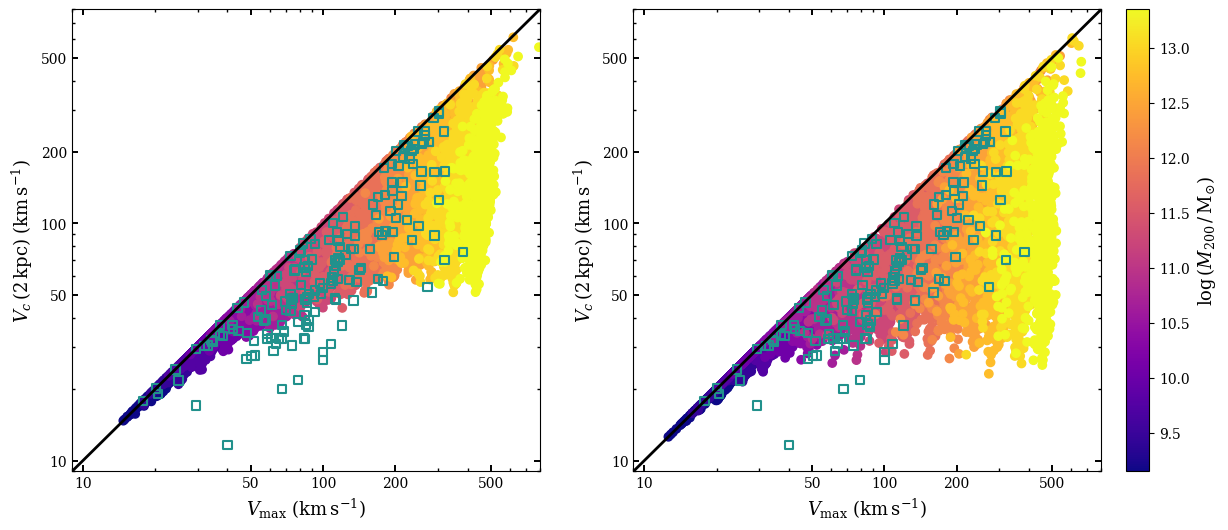

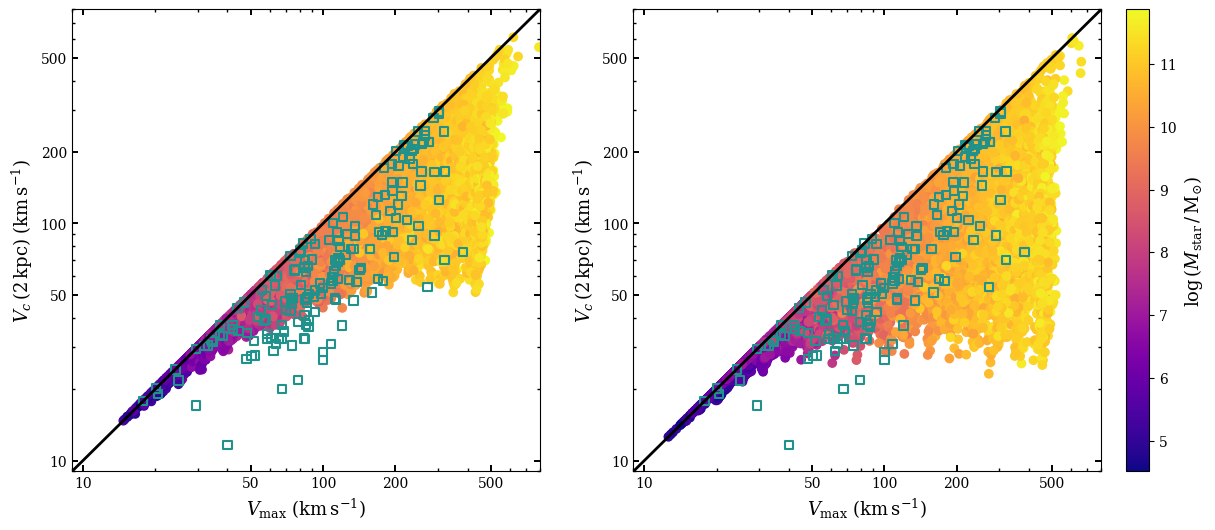

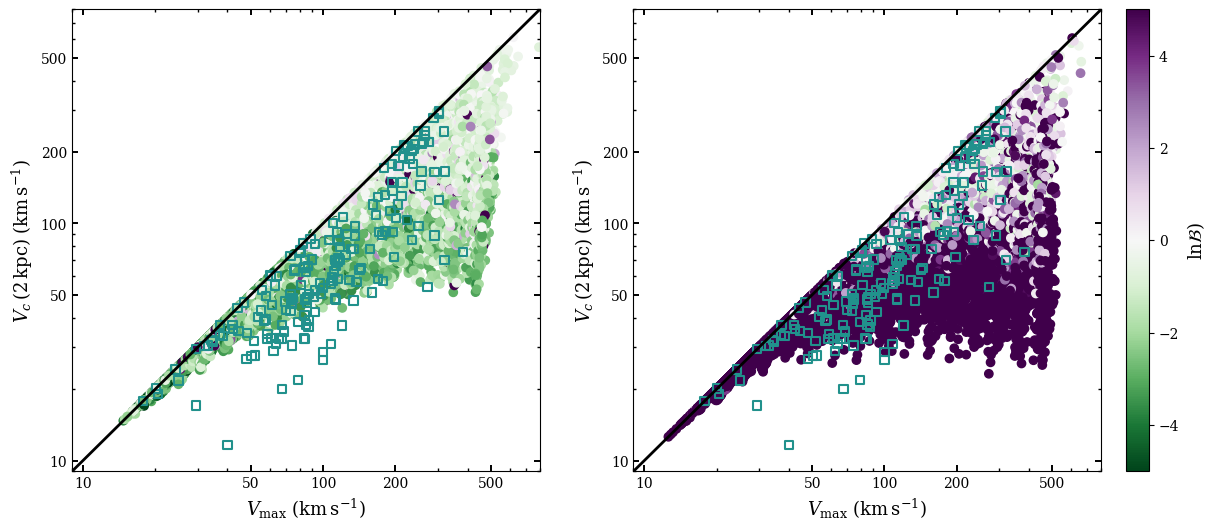

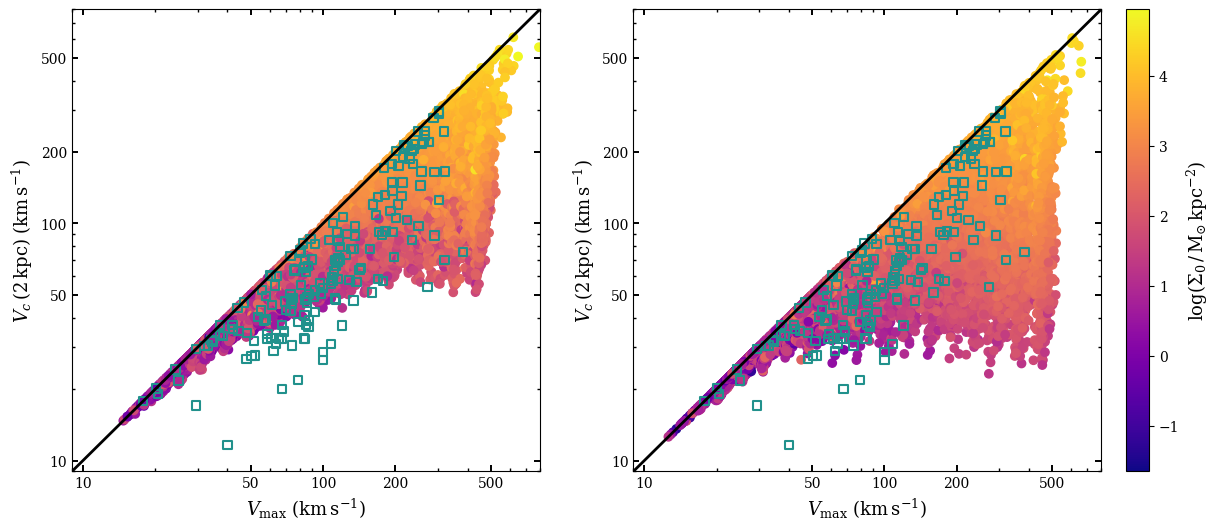

In [155]:
plot_diversity([vmax_2n,vmax_2c],[v2_2n,v2_2c],[lm_2n,lm_2c]);
plot_diversity([vmax_2n,vmax_2c],[v2_2n,v2_2c],[lms_2n,lms_2c],
               cblabel = '$\mathrm{log}\,(M_{\mathrm{star}}\,/\,\mathrm{M_{\odot}}}$)');
plot_diversity([vmax_2n,vmax_2c],[v2_2n,v2_2c],[lz_2n,lz_2c],cmap = pa.prgn_r,
               cblabel = '$\mathrm{ln}\mathcal{B}$)',v_max = 5,v_min = -5);
plot_diversity([vmax_2n,vmax_2c],[v2_2n,v2_2c],[lsig_2n-6,lsig_2c-6],
               cblabel = '$\mathrm{log}(\Sigma_0\,/\,\mathrm{M_{\odot}\,kpc^{-2}})$');
plt.savefig('../Output/diversity/Bry_2sig_diversity.png',dpi = 300, bbox_inches = 'tight')

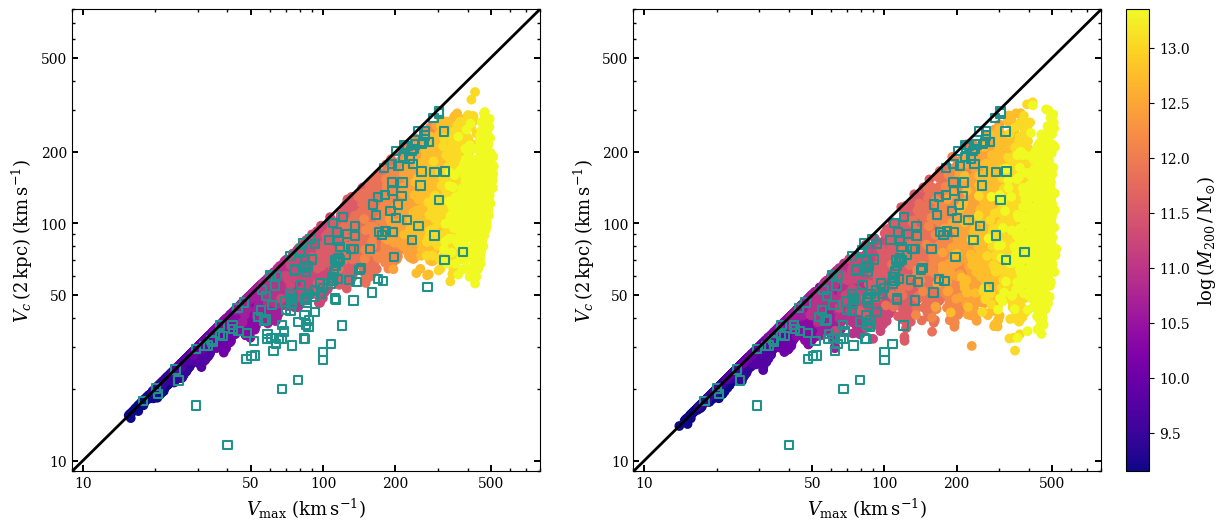

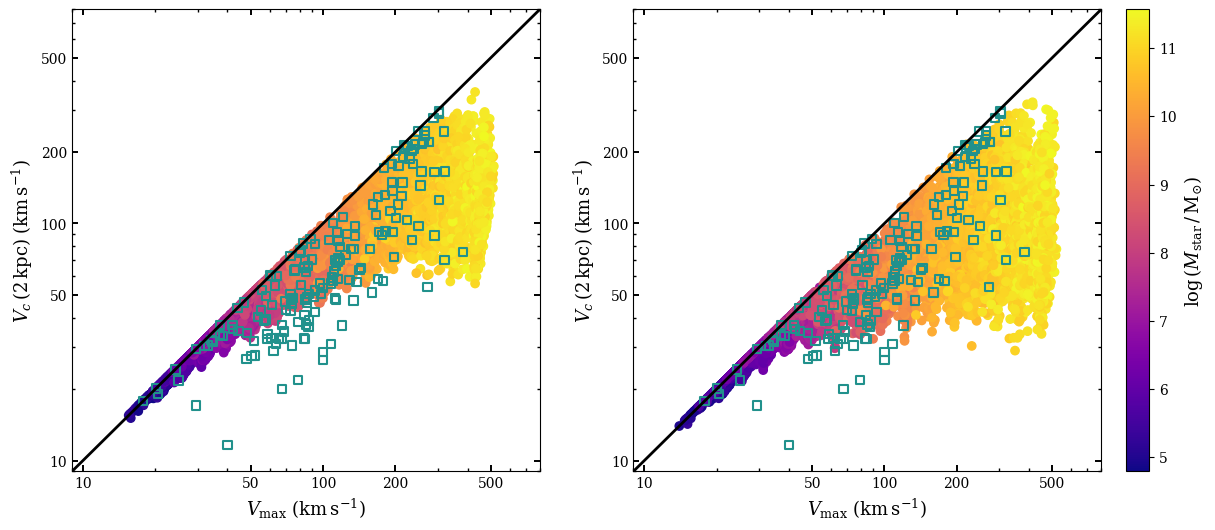

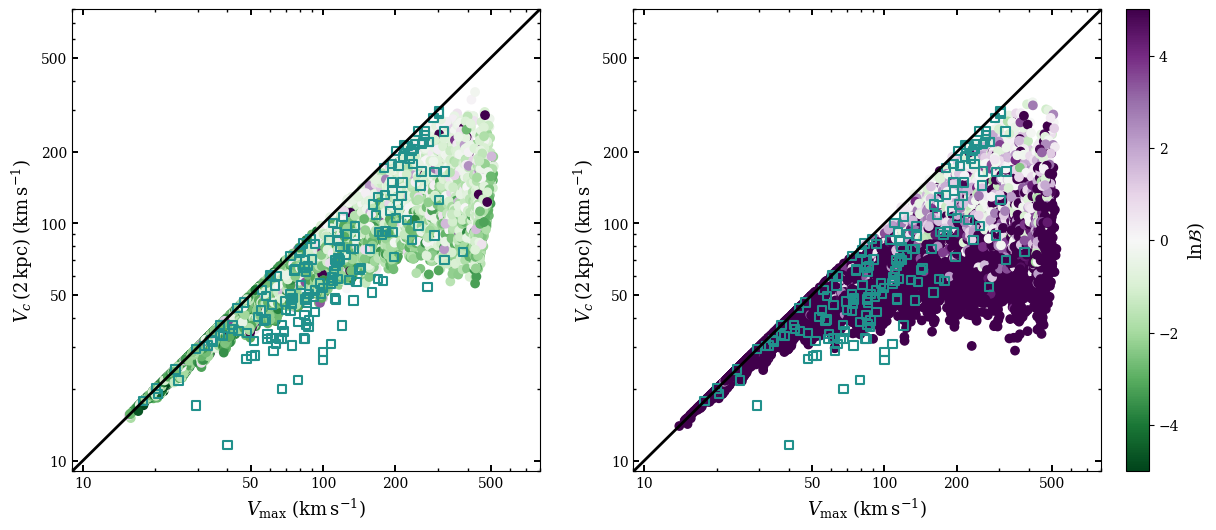

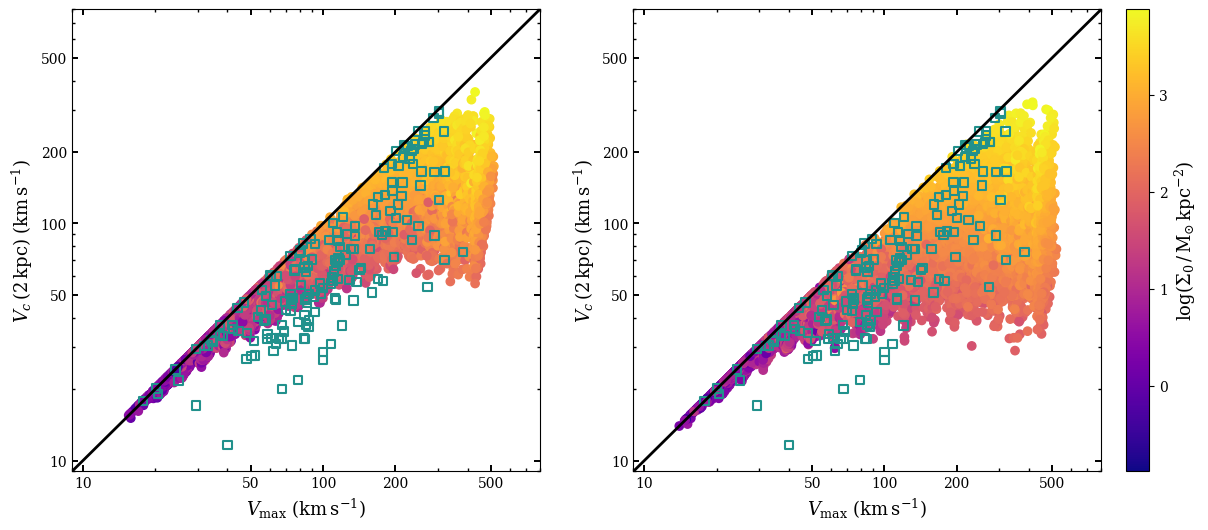

In [152]:
plot_diversity([vmax_1n,vmax_1c],[v2_1n,v2_1c],[lm_1n,lm_1c]);
plot_diversity([vmax_1n,vmax_1c],[v2_1n,v2_1c],[lms_1n,lms_1c],
               cblabel = '$\mathrm{log}\,(M_{\mathrm{star}}\,/\,\mathrm{M_{\odot}}}$)');
plot_diversity([vmax_1n,vmax_1c],[v2_1n,v2_1c],[lz_1n,lz_1c],cmap = pa.prgn_r,
               cblabel = '$\mathrm{ln}\mathcal{B}$)',v_max = 5,v_min = -5);
plot_diversity([vmax_1n,vmax_1c],[v2_1n,v2_1c],[lsig_1n-6,lsig_1c-6],
               cblabel = '$\mathrm{log}(\Sigma_0\,/\,\mathrm{M_{\odot}\,kpc^{-2}})$');
plt.savefig('../Output/diversity/bry_1sig_diversity.png',dpi = 300, bbox_inches = 'tight')

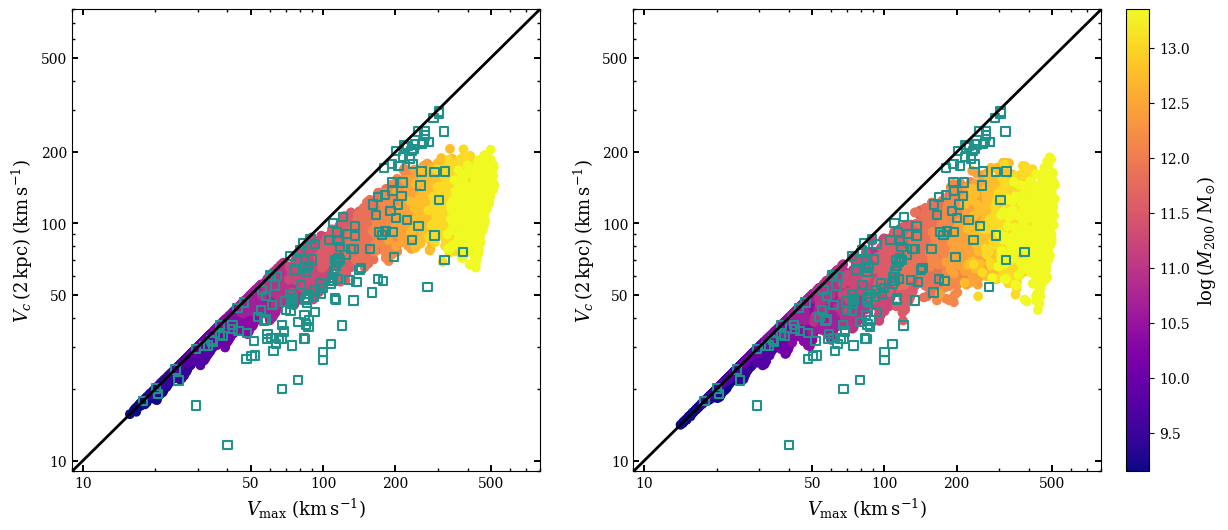

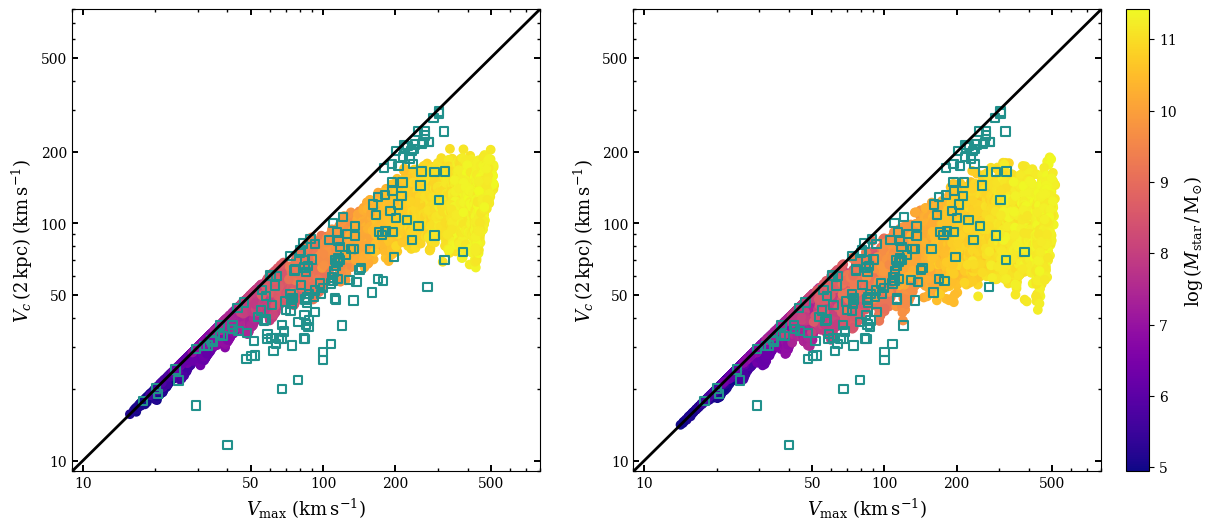

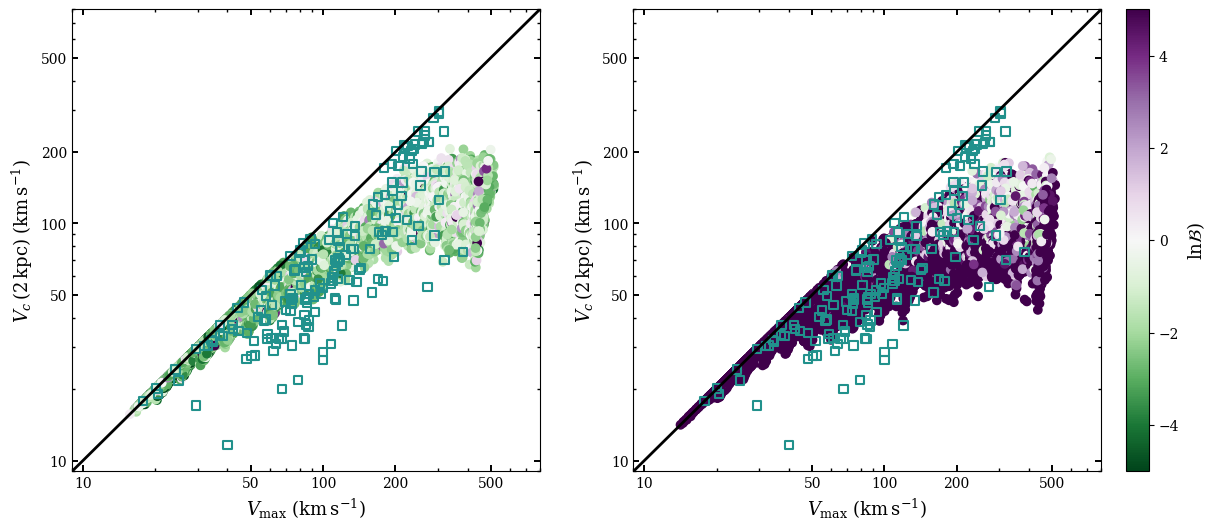

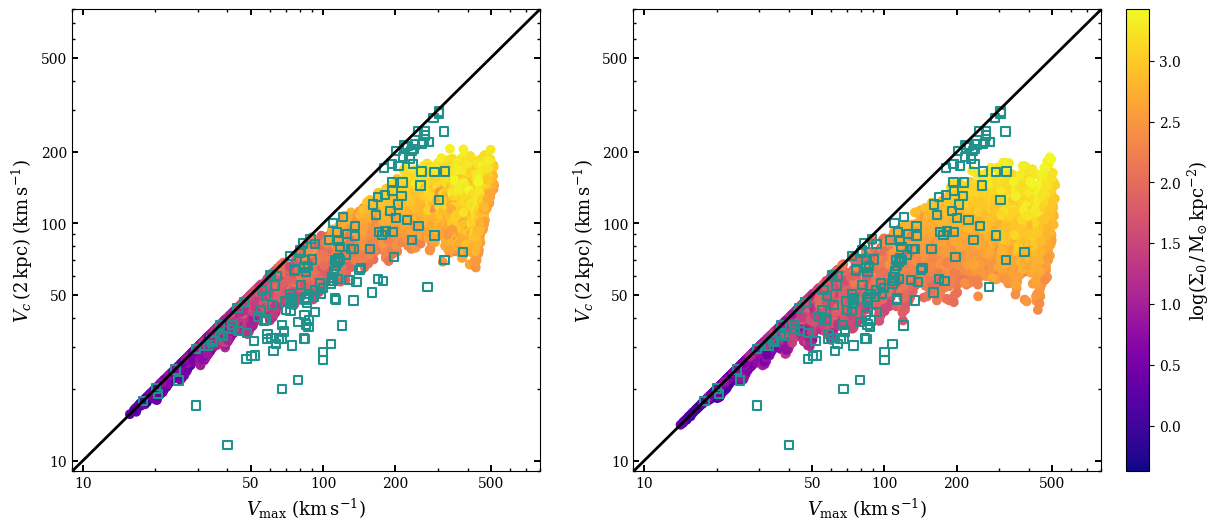

In [154]:
plot_diversity([vmax_p5n,vmax_p5c],[v2_p5n,v2_p5c],[lm_p5n,lm_p5c]);
plot_diversity([vmax_p5n,vmax_p5c],[v2_p5n,v2_p5c],[lms_p5n,lms_p5c],
               cblabel = '$\mathrm{log}\,(M_{\mathrm{star}}\,/\,\mathrm{M_{\odot}}}$)');
plot_diversity([vmax_p5n,vmax_p5c],[v2_p5n,v2_p5c],[lz_p5n,lz_p5c],cmap = pa.prgn_r,
               cblabel = '$\mathrm{ln}\mathcal{B}$)',v_max = 5,v_min = -5);
plot_diversity([vmax_p5n,vmax_p5c],[v2_p5n,v2_p5c],[lsig_p5n-6,lsig_p5c-6],
               cblabel = '$\mathrm{log}(\Sigma_0\,/\,\mathrm{M_{\odot}\,kpc^{-2}})$');
plt.savefig('../Output/diversity/bry_p5sig_diveristy.png',bbox_inches = 'tight',dpi = 300)

In [21]:
label_gals_n,label_gals_c = [],[]
for i in range(len(gals)):
    gal,vm,v2 = gals[i],vm_R[i],v2_R[i]
    if (50 < vm < 100) and (v2 < 25):
        print (gal)
        label_gals_c.append(gal)
        label_gals_n.append(gal)
    if (25 < vm < 50) and (v2 < 20):
        print (gal)
        label_gals_c.append(gal)
        label_gals_n.append(gal)
    if (95 < vm < 110) and (v2 < 32):
        print ('--',gal)
        label_gals_n.append(gal)
    if (110 < vm < 130) and (v2 < 40):
        print ('---',gal)
        label_gals_n.append(gal)

F563-V1
--- F568-3
F574-2
IC2574
-- UGC00634
-- UGC05005
UGC05750
-- UGC05999


In [299]:
core_hig,cusp_hig = {},{}
prior = 'lcdm_vmax_shm'
for i in range(len(gals)):
    gal,vm,v2 = gals[i],vm_R[i],v2_R[i]
    try:
        model = sparcd[prior][gal]['best_fit']
    except:
        continue
    gald = sparcd[prior][gal][model]
    dlz = sparcd[prior][gal]['core_fit']['lnZ'] - sparcd[prior][gal]['cusp_fit']['lnZ']
    if vm > 200 and v2 < 100:
        # if model == 'cusp_fit':
        if dlz > 1:
            core_hig[gal] = [vm,v2]
        if dlz < -1:
            cusp_hig[gal] = [vm,v2]

In [1097]:
galext = 'UGC05721'
prior = 'lcdm_vmax_shm'
r = np.array(sparcd[prior][galext]['r'])
vc = np.array(sparcd[prior][galext]['vc'])
ve = np.array(sparcd[prior][galext]['ve'])
vmext = np.max(vc)
v2ext = v2kpc(r,vc)

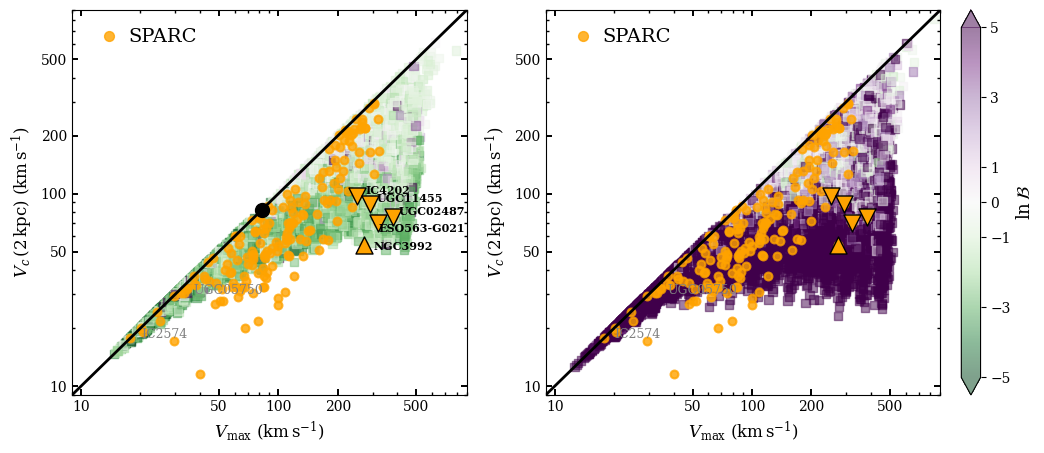

In [1098]:
fig,axs = plt.subplots(1,2,figsize = (13.5,5),gridspec_kw = {'wspace':0.2})
ax1,ax2 = axs
ax1.scatter(vmax_2n,v2_2n, c = lz_2n, cmap = pa.prgn_r,alpha = 0.5,vmin = -5, vmax = 5,marker = 's')
sc = ax2.scatter(vmax_2c,v2_2c, c = lz_2c, cmap = pa.prgn_r,alpha = 0.5,vmin = -5, vmax = 5,marker = 's')
cb = fig.colorbar(sc, ax=axs.ravel().tolist(),pad = 0.02,extend = 'both')
cb.set_ticks([-5,-3,-1,0,1,3,5])
cb.set_label(label = '$\mathrm{ln}\,\mathcal{B}$',size = 13)

# ax2.scatter(vmax_cc,v2_cc, c = lm_cc, cmap = plt.get_cmap('copper'),alpha = 0.1)
# clr = plt.get_cmap('viridis')(0.4)
clr = (1,.64,0)
# clr = (0,.4,.7)
ticks = [10,50,100,200,500]
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(vm_R,v2_R,color = clr,marker = 'o',lw = 1.5,alpha = 0.8,s = 32)
    ax.set_xlim(9e0,9e2)
    ax.set_ylim(9e0,9e2)
    ax.plot(ax.get_xlim(),ax.get_ylim(),c = 'k',lw = 2)
    ax.tick_params(direction = 'in',which = 'both',width = 1,length = 2,top=True,right=True)
    ax.tick_params(which = 'major',length = 4,width = 1.4)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_xlabel('$V_{\mathrm{max}}$ $(\mathrm{km\,s^{-1})}$',size = 12)
    ax.set_ylabel('$V_c\,(2\,\mathrm{kpc})$ $(\mathrm{km\,s^{-1}})$',size = 12)
    ax.scatter(1e4,1e4,color = clr,marker = 'o',lw = 1,alpha = 0.8,s = 50,label = 'SPARC')
    ax.legend(loc = 'upper left', prop={'size':14},framealpha = 0,labelspacing = 1,handletextpad= 0)


clrs = ['k',(0.9,0.9,0.9)]
for i in range(2):
    ax = axs[i]
    for gal in core_hig:
        ax.scatter(core_hig[gal][0],core_hig[gal][1],marker = 'v',color = clr,s = 150,edgecolor = 'k')
        if i == 0:
            if gal in ['IC4202','UGC11455','UGC02487']:
                ax.text(core_hig[gal][0]+25,core_hig[gal][1],gal,color = clrs[i],size = 8,verticalalignment = 'bottom',weight = 'bold')
            if gal in ['ESO563-G021']:
                ax.text(core_hig[gal][0],core_hig[gal][1],gal,color = clrs[i],size = 8,verticalalignment = 'top',weight = 'bold')
    for gal in cusp_hig:
        ax.scatter(cusp_hig[gal][0],cusp_hig[gal][1],marker = '^',color= clr, s = 150, edgecolor = 'k')
        if i == 0:
            ax.text(cusp_hig[gal][0]+30,cusp_hig[gal][1]-3,gal,color = 'k',size = 8,weight = 'bold')

    
clr2 = 'grey'#plt.get_cmap('Reds')(0.95)
for i in range(len(gals)):
    gal = gals[i]
    if gal == 'UGC05005':
        continue
    vm,v2 = vm_R[i],v2_R[i]
    if gal in label_gals_c:
        ax2.text(vm,v2,gal,size = 9, color = clr2,verticalalignment = 'top',alpha = 1)
    if gal in label_gals_n:
        ax1.text(vm,v2,gal,size = 9, color = clr2,verticalalignment = 'top',alpha = 1)


# plt.savefig('../Output/plots_for_report/diversity_lnB_cusp_core.pdf',dpi = 300, bbox_inches = 'tight')

0.77
0.62
9.93
0.45
9.19


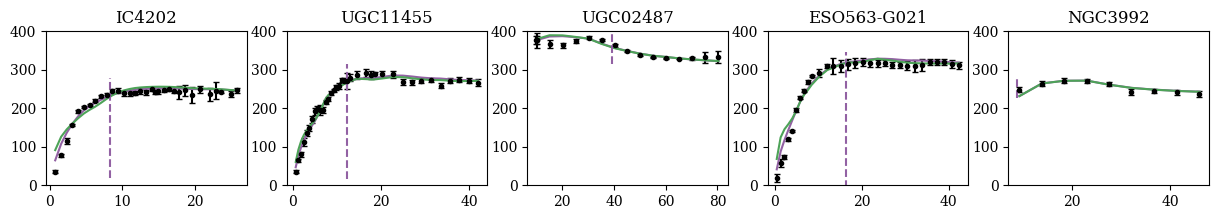

In [1010]:
fig,axs = plt.subplots(1,5,figsize = (3*5,2))
extragals = ['IC4202','UGC11455','UGC02487','ESO563-G021','NGC3992']
for i in range(5):
    gal = extragals[i]
    r = sparcd['flat'][gal]['r']
    vc = sparcd['flat'][gal]['vc']
    ve = sparcd['flat'][gal]['ve']
    vmn = sparcd['lcdm'][gal]['cusp_fit']['vcmodel']
    vmc = sparcd['lcdm'][gal]['core_fit']['vcmodel']
    r1 = sparcd['lcdm'][gal]['core_fit']['r1'][0]
    rsn = sparcd['lcdm'][gal]['cusp_fit']['rs'][0]
    rsc = sparcd['lcdm'][gal]['core_fit']['rs'][0]
    ax = axs[i]
    ax.errorbar(r,vc,ve,fmt = '.',color = 'k',capsize = 2)
    ax.plot(r,vmc,c = pa.purple)
    ax.plot(r,vmn,c = pa.green)
    # ax.plot([rsn,rsn],ax.get_ylim(), c = pa.green)
    # ax.plot([rsc,rsc],ax.get_ylim(), c = pa.purple)
    ax.plot([r1,r1],ax.get_ylim(), c = pa.purple, ls = '--')
    ax.set_title(gal)
    ax.set_ylim(0,400)
    print (r[0])

10.23 67.5
22.85 78.9


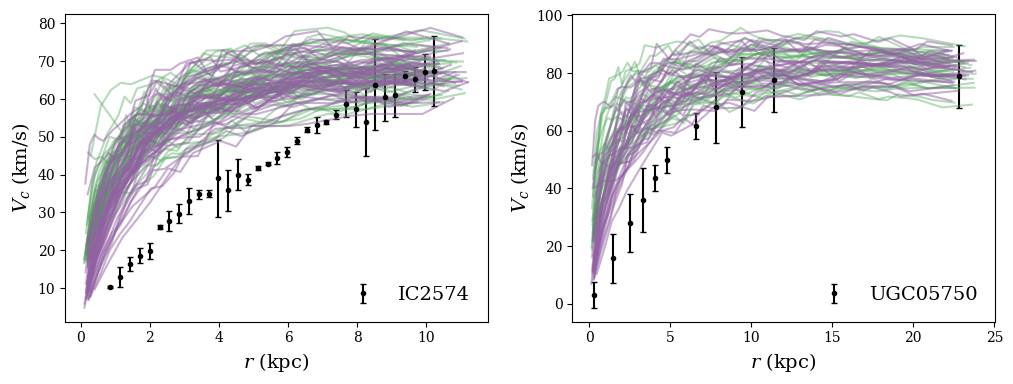

In [96]:
fig,axs = plt.subplots(1,2,figsize = (12,4))
gals = ['IC2574','UGC05750']

for j in range(2):
    IC = gals[j]
    ax = axs[j]
    ICdata = np.loadtxt('../../Accessory/RotCurvs/%s_rotmod.dat'%IC)
    ax.errorbar(ICdata[:,0],ICdata[:,1],ICdata[:,2],fmt = '.',c = 'k',capsize = 2,label = IC)
    # ax.set_xlim(0,10)
    ax.set_xlabel('$r$ (kpc)',size = 14)
    ax.set_ylabel('$V_c$ (km/s)',size = 14)
    ax.legend(loc = 'lower right', prop={'size':14},framealpha = 0,labelspacing = 0.1)

    rlast = ICdata[:,0][-1]
    vlast = ICdata[:,1][-1]
    elast = ICdata[:,2][-1]
    print (rlast,vlast)

    for model in ['N','S']:
        for lm_i in range(15):
            for rn_i in range(15):
                clr = pa.green if model == 'N' else pa.purple
                alp = 0.4 if model == 'N' else 0.5
                for i in range(50):
                    gal = '%i_%i_%s_gal_%i'%(lm_i,rn_i,model,i)
                    data = np.loadtxt('../../sim_RC_12/Output/Mock_gals/Bry_2sig_gals/%s.dat'%gal)
                    r,v = data[:,0],data[:,1]
                    if np.abs(vlast - v[-1]) <= elast:
                        if np.abs(rlast - r[-1]) <= 1:
                            ax.plot(r,v,c = clr, alpha = alp)


plt.savefig('../Output/plots_for_report/Outliers.pdf',dpi = 300,bbox_inches = 'tight')

10.23 67.5
22.85 78.9


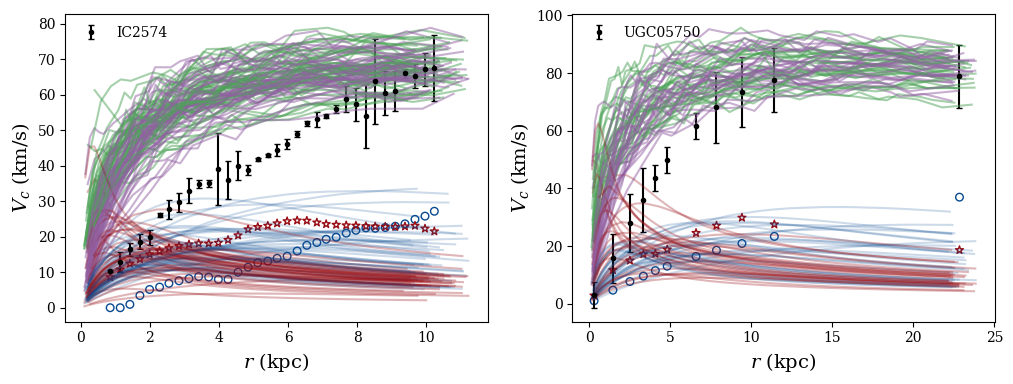

In [1012]:
fig,axs = plt.subplots(1,2,figsize = (12,4))
gals = ['IC2574','UGC05750']
red = plt.get_cmap('Reds')(0.9)
lightred = (1.,.647,0)
blue = plt.get_cmap('Blues')(0.9)
lightblue = (0,0.8,0.8)
# red = 'r'
# blue = 'b'

for j in range(2):
    IC = gals[j]
    ax = axs[j]
    ICdata = np.loadtxt('../../Accessory/RotCurvs/%s_rotmod.dat'%IC)
    ax.errorbar(ICdata[:,0],ICdata[:,1],ICdata[:,2],fmt = '.',c = 'k',capsize = 2,label = '%s'%IC)
    ax.scatter(ICdata[:,0],ICdata[:,3],marker = 'o',color = blue,lw = 1,facecolor = 'none',s = 30)
    ICyd = sparcd['lcdm'][IC]['core_fit']['yd'][0]
    ax.scatter(ICdata[:,0],np.sqrt(ICyd)*ICdata[:,4],marker = '*',color = red,lw = 1,facecolor = 'none')

    rlast = ICdata[:,0][-1]
    vlast = ICdata[:,1][-1]
    elast = ICdata[:,2][-1]
    print (rlast,vlast)
    ax.legend(loc = 'upper left',framealpha = 0)
    

    for lm_i in range(15):
        for rn_i in range(15):
            for model in ['N','S']:
                clr = pa.green if model == 'N' else pa.purple
                for i in range(50):
                    gal = '%i_%i_%s_gal_%i'%(lm_i,rn_i,model,i)
                    data = np.loadtxt('../../sim_RC_12/Output/Mock_gals/Bry_2sig_gals/%s.dat'%gal)
                    r,v = data[:,0],data[:,1]
                    if np.abs(vlast - v[-1]) <= elast:
                        if np.abs(rlast - r[-1]) <= 1:
                            ax.plot(r,v,c = clr, alpha = 0.5)
                            if model == 'S':
                                ax.plot(r,data[:,3],c = blue,alpha = 0.2)
                                yd = bry_2[gal]['original']['yd']
                                ax.plot(r,np.sqrt(yd)*data[:,4],c = red,alpha = 0.3)
                                
for ax in axs:
    ax.set_xlabel('$r$ (kpc)',size = 14)
    ax.set_ylabel('$V_c$ (km/s)',size = 14)
    
plt.savefig('../Output/plots_for_report/Outliers_with_bary.pdf',bbox_inches = 'tight',dpi = 300)

# Diversity plots for report

In [969]:
rc_p7 = json.load(open('../../sim_RC_12/Output/resdicts/Rc_p7_original.json','r'))
rc_p3 = json.load(open('../../sim_RC_12/Output/resdicts/Rc_p3_original.json','r'))
dmo = json.load(open('../../sim_RC_12/Output/resdicts/dmo_original.json','r'))
Bry_p25 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_p25sig_original.json','r'))
Rd_1 = json.load(open('../../sim_RC_12/Output/resdicts/Rd_1_original.json','r'))
Rd_p5 = json.load(open('../../sim_RC_12/Output/resdicts/Rd_p5_original.json','r'))
Bry_2 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_2sig_original.json','r'))
Bry_1 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_1sig_original.json','r'))
Bry_p5 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_p5sig_original.json','r'))
sig_shm = json.load(open('../../sim_RC_12/Output/resdicts/sig_SHM_original.json','r'))
rc_m1 = json.load(open('../../sim_RC_12/Output/resdicts/Rc_m1_original.json','r'))
rc_m2 = json.load(open('../../sim_RC_12/Output/resdicts/Rc_m2_original.json','r'))

In [513]:
def get_vmax_v2(gald,model,keys=[]):
    vmax,v2 = [],[]
    extras = {key:[] for key in keys}
    for gal in gald:
        if model in gal:
            vmax.append(gald[gal]['vmax'])
            v2.append(gald[gal]['v2'])
            for key in keys:
                extras[key].append(gald[gal][key])
    for key in extras.keys():
        extras[key] = np.array(extras[key])
    return np.array(vmax),np.array(v2), extras

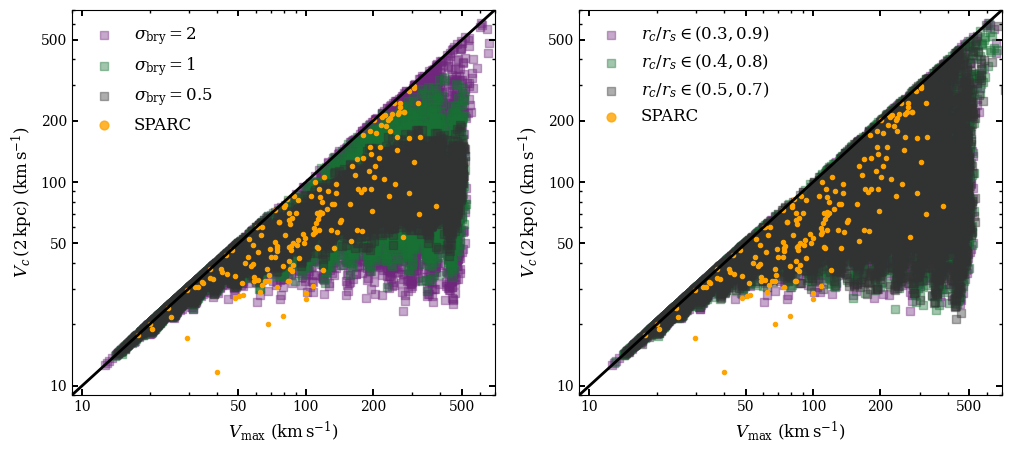

In [987]:
fig,axs = plt.subplots(1,2,figsize = (12,5),gridspec_kw = {'wspace':0.2})
ax2,ax1 = axs

c1 = pa.pr(0.8)
c2 = pa.gn(0.2)
c3 = (0.2,0.2,0.2)
# c3 = (0.15,0.5,0.85)
mrk = 's'

vm,v2,_ = get_vmax_v2(Bry_2,'S')
ax1.scatter(vm,v2, color = c1,marker = mrk,alpha = 0.4,label = '$r_c/r_s \in (0.3,0.9)$',edgecolor = c1,s = 40)
vm,v2,_ = get_vmax_v2(rc_m1,'S')
ax1.scatter(vm,v2, color = c2,marker = mrk,alpha = 0.4,label = '$r_c/r_s \in (0.4,0.8)$',edgecolor = c2,s = 40)
vm,v2,_ = get_vmax_v2(rc_m2,'S')
ax1.scatter(vm,v2, color = c3,marker = mrk,alpha = 0.4,label = '$r_c/r_s \in (0.5,0.7)$',edgecolor = c3,s = 40)

vm,v2,_ = get_vmax_v2(Bry_2,'S')
ax2.scatter(vm,v2, color = c1,marker = mrk,alpha = 0.4,label = '$\sigma_{\mathrm{bry}} = 2$',edgecolor = c1,s = 40)
vm,v2,_ = get_vmax_v2(Bry_1,'S')
ax2.scatter(vm,v2, color = c2,marker = mrk,alpha = 0.4,label = '$\sigma_{\mathrm{bry}} = 1$',edgecolor = c2,s = 40)
vm,v2,_ = get_vmax_v2(Bry_p5,'S')
ax2.scatter(vm,v2, color = c3,marker = mrk,alpha = 0.4,label = '$\sigma_{\mathrm{bry}} = 0.5$',edgecolor = c3,s = 40)

clr = (1,.64,0)
ticks = [10,50,100,200,500]
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(vm_R,v2_R,color = clr,marker = 'o',lw = 0.8,alpha = 1,s = 10)
    ax.set_xlim(9e0,7e2)
    ax.set_ylim(9e0,7e2)
    ax.plot(ax.get_xlim(),ax.get_ylim(),c = 'k',lw = 2)
    ax.tick_params(direction = 'in',which = 'both',width = 1,length = 2,top=True,right=True)
    ax.tick_params(which = 'major',length = 4,width = 1.4)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_xlabel('$V_{\mathrm{max}}$ $(\mathrm{km\,s^{-1})}$',size = 12)
    ax.set_ylabel('$V_c\,(2\,\mathrm{kpc})$ $(\mathrm{km\,s^{-1}})$',size = 12)
    ax.scatter(1e4,1e4,color = clr,marker = 'o',lw = 1,label = 'SPARC',alpha = 0.8,s = 40)
    ax.legend(loc = 'upper left', prop={'size':12},framealpha = 0,labelspacing = .5,markerscale = 1)
    
plt.savefig('../Output/plots_for_report/diversity_diff_bry_rcbyrs_scatter.pdf',bbox_inches = 'tight',dpi = 300)

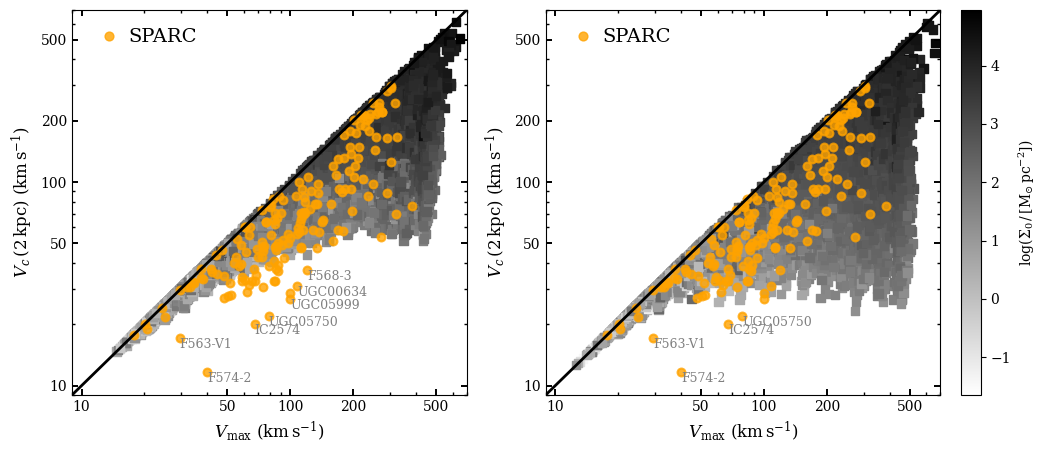

In [953]:
fig,axs = plt.subplots(1,2,figsize = (13.5,5),gridspec_kw = {'wspace':0.2})
ax1,ax2 = axs

vm,v2,ex = get_vmax_v2(Bry_2,'N',['lsig'])
sc = ax1.scatter(vm,v2, c = ex['lsig'], cmap = plt.get_cmap('gray_r'),marker = 's',
                 alpha = 1)
vm,v2,ex = get_vmax_v2(Bry_2,'S',['lsig'])
sc = ax2.scatter(vm,v2, c = ex['lsig'],cmap = plt.get_cmap('gray_r'),marker = 's',
            alpha = 1)
cb = fig.colorbar(sc, ax=axs.ravel().tolist(),pad = 0.02,label = 'log$(\Sigma_0\,/\,[\mathrm{M_{\odot}\,pc^{-2}}])$')

clr = (1,.64,0)
ticks = [10,50,100,200,500]
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(vm_R,v2_R,color = clr,marker = 'o',lw = 1.5,alpha = 0.8,s = 32)
    ax.set_xlim(9e0,7e2)
    ax.set_ylim(9e0,7e2)
    ax.plot(ax.get_xlim(),ax.get_ylim(),c = 'k',lw = 2)
    ax.tick_params(direction = 'in',which = 'both',width = 1,length = 2,top=True,right=True)
    ax.tick_params(which = 'major',length = 4,width = 1.4)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_xlabel('$V_{\mathrm{max}}$ $(\mathrm{km\,s^{-1})}$',size = 12)
    ax.set_ylabel('$V_c\,(2\,\mathrm{kpc})$ $(\mathrm{km\,s^{-1}})$',size = 12)
    ax.scatter(1e4,1e4,color = clr,marker = 'o',lw = 1,label = 'SPARC',alpha = 0.8,s = 40)
    ax.legend(loc = 'upper left', prop={'size':14},framealpha = 0,labelspacing = .1,handletextpad = 0)
    
clr2 = 'grey'#plt.get_cmap('Reds')(0.95)
for i in range(len(gals)):
    gal = gals[i]
    if gal == 'UGC05005':
        continue
    vm,v2 = vm_R[i],v2_R[i]
    if gal in label_gals_c:
        ax2.text(vm,v2,gal,size = 9, color = clr2,verticalalignment = 'top',alpha = 1)
    if gal in label_gals_n:
        ax1.text(vm,v2,gal,size = 9, color = clr2,verticalalignment = 'top',alpha = 1)
    
plt.savefig('../Output/plots_for_report/diversity_bry_2_lsig.pdf',bbox_inches = 'tight',dpi = 300)

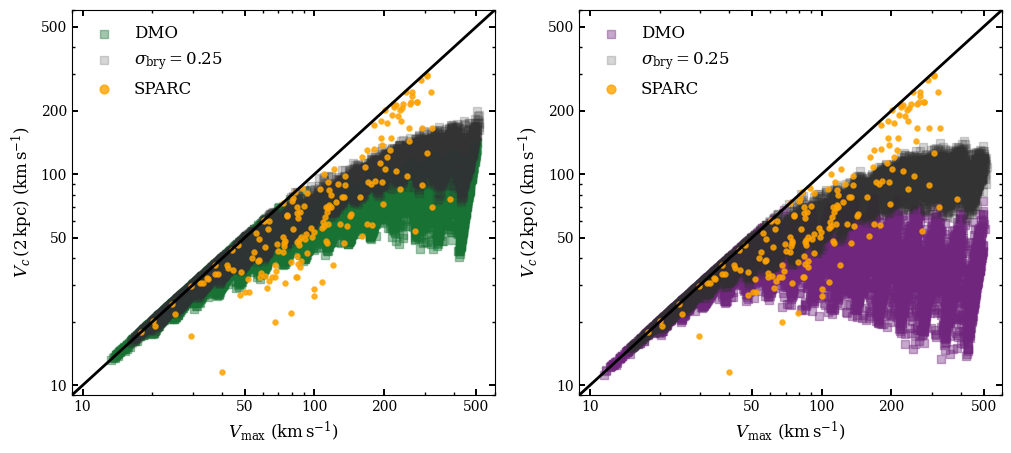

In [995]:
fig,axs = plt.subplots(1,2,figsize = (12,5),gridspec_kw = {'wspace':0.2})
ax1,ax2 = axs

c1 = pa.pr(0.8)
c2 = pa.gn(0.2)
c3 = (0.2,0.2,0.2)

vm,v2,_ = get_vmax_v2(dmo,'N')
ax1.scatter(vm,v2, color = c2, marker = 's',alpha = 0.4,label = 'DMO')
vm,v2,_ = get_vmax_v2(Bry_p25,'N')
ax1.scatter(vm,v2, color = c3, marker = 's',alpha = 0.2,label = '$\sigma_{\mathrm{bry}} = 0.25$')
vm,v2,_ = get_vmax_v2(dmo,'S')
ax2.scatter(vm,v2, color = c1, marker = 's',alpha = 0.4,label = 'DMO')
vm,v2,_ = get_vmax_v2(Bry_p25,'S')
ax2.scatter(vm,v2, color = c3, marker = 's',alpha = 0.2,label = '$\sigma_{\mathrm{bry}} = 0.25$',)

clr = (1,.64,0)
ticks = [10,50,100,200,500]
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(vm_R,v2_R,color = clr,marker = 'o',lw = 1.5,alpha = 0.8,s = 10)
    ax.set_xlim(9e0,6e2)
    ax.set_ylim(9e0,6e2)
    ax.plot(ax.get_xlim(),ax.get_ylim(),c = 'k',lw = 2)
    ax.tick_params(direction = 'in',which = 'both',width = 1,length = 2,top=True,right=True)
    ax.tick_params(which = 'major',length = 4,width = 1.4)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_xlabel('$V_{\mathrm{max}}$ $(\mathrm{km\,s^{-1})}$',size = 12)
    ax.set_ylabel('$V_c\,(2\,\mathrm{kpc})$ $(\mathrm{km\,s^{-1}})$',size = 12)
    ax.scatter(1e4,1e4,color = clr,marker = 'o',lw = 1,label = 'SPARC',alpha = 0.8,s = 40)
    ax.legend(loc = 'upper left', prop={'size':12},framealpha = 0,labelspacing = 0.5,markerscale = 1)
    
plt.savefig('../Output/plots_for_report/diversity_dmo_bry_p25.pdf',bbox_inches = 'tight',dpi = 300)

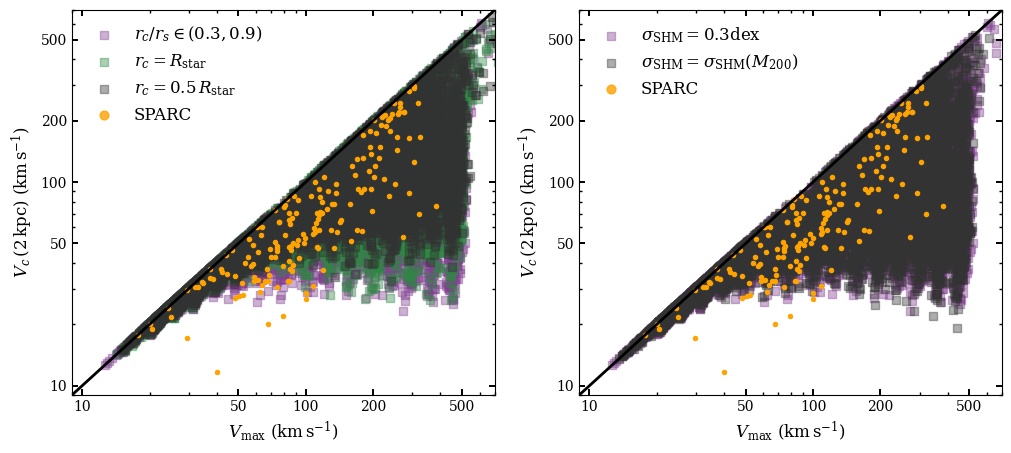

In [996]:
fig,axs = plt.subplots(1,2,figsize = (12,5),gridspec_kw = {'wspace':0.2})
ax1,ax2 = axs

c1 = pa.pr(0.7)
c2 = pa.gn(0.3)
c3 = (0.2,0.2,0.2)
mrk = 's'

vm,v2,_ = get_vmax_v2(Bry_2,'S')
ax1.scatter(vm,v2, color = c1,marker = mrk,alpha = 0.4,label = '$r_c/r_s \in (0.3,0.9)$',edgecolor = c1,s = 40)
vm,v2,_ = get_vmax_v2(Rd_1,'S')
ax1.scatter(vm,v2, color = c2,marker = mrk,alpha = 0.4,label = '$r_c = R_{\mathrm{star}}$',edgecolor = c2,s = 40)
vm,v2,_ = get_vmax_v2(Rd_p5,'S')
ax1.scatter(vm,v2, color = c3,marker = mrk,alpha = 0.4,label = '$r_c = 0.5\,R_{\mathrm{star}}$',edgecolor = c3,s = 40)

vm,v2,_ = get_vmax_v2(Bry_2,'S')
ax2.scatter(vm,v2, color = c1,marker = mrk,alpha = 0.4,label = '$\sigma_{\mathrm{SHM}} = 0.3$dex',edgecolor = c1,s = 40)
vm,v2,_ = get_vmax_v2(sig_shm,'S')
ax2.scatter(vm,v2, color = c3,marker = mrk,alpha = 0.4,
            label = '$\sigma_{\mathrm{SHM}} = \sigma_{\mathrm{SHM}}(M_{200})$',edgecolor = c3,s = 40)


clr = (1,.64,0)
ticks = [10,50,100,200,500]
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(vm_R,v2_R,color = clr,marker = 'o',lw = 0.8,alpha = 1,s = 10)
    ax.set_xlim(9e0,7e2)
    ax.set_ylim(9e0,7e2)
    ax.plot(ax.get_xlim(),ax.get_ylim(),c = 'k',lw = 2)
    ax.tick_params(direction = 'in',which = 'both',width = 1,length = 2,top=True,right=True)
    ax.tick_params(which = 'major',length = 4,width = 1.4)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_xlabel('$V_{\mathrm{max}}$ $(\mathrm{km\,s^{-1})}$',size = 12)
    ax.set_ylabel('$V_c\,(2\,\mathrm{kpc})$ $(\mathrm{km\,s^{-1}})$',size = 12)
    ax.scatter(1e4,1e4,color = clr,marker = 'o',lw = 1,label = 'SPARC',alpha = 0.8,s = 40)
    ax.legend(loc = 'upper left', prop={'size':12},framealpha = 0,labelspacing = .5,markerscale = 1)
    
plt.savefig('../Output/plots_for_report/diversity_rc_Rstar_SHM_scatter.pdf',bbox_inches = 'tight',dpi = 300)

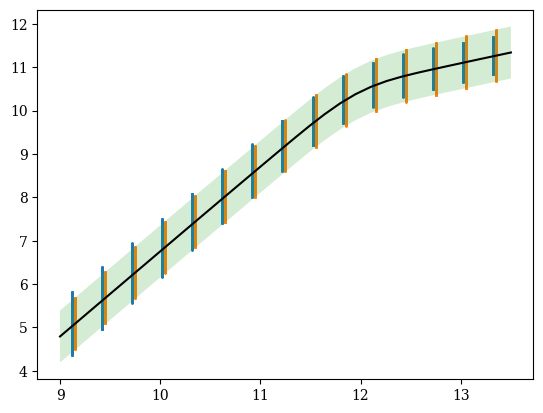

In [703]:
lmstar,lm200 = [],[]
for gal in sig_shm:
    if 'S' in gal:
        lm200.append(sig_shm[gal]['lm']-0.03)
        lmstar.append(sig_shm[gal]['lmstar'])
plt.scatter(lm200,lmstar,s = 1)

lmstar,lm200 = [],[]
for gal in Bry_2:
    if 'S' in gal:
        lm200.append(Bry_2[gal]['lm'])
        lmstar.append(Bry_2[gal]['lmstar'])
plt.scatter(lm200,lmstar,s = 1)

lm = np.linspace(9,13.5,30)
ls = pnp.lmstar_behroozi_19(lm)
plt.plot(lm,ls,c = 'k')
plt.fill_between(lm,ls+0.6,ls-0.6, alpha = 0.2)

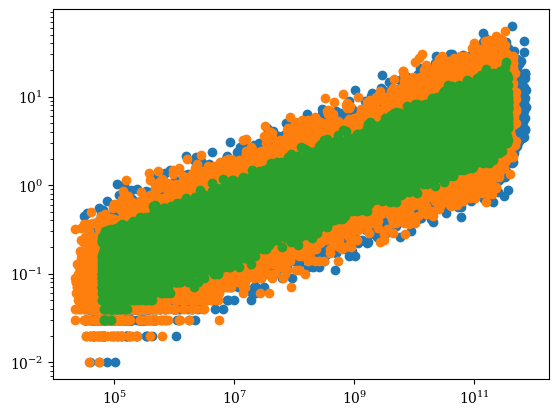

In [867]:
lmstar_bry2,rdstar_bry2 = [],[]
for gal in Bry_2:
    rdstar_bry2.append(Bry_2[gal]['rdstar'])
    lmstar_bry2.append(Bry_2[gal]['lmstar'])
plt.scatter(10**np.array(lmstar_bry2),rdstar_bry2)
plt.xscale('log')
plt.yscale('log')

lmstar_shm,rdstar_shm = [],[]
for gal in sig_shm:
    rdstar_shm.append(sig_shm[gal]['rdstar'])
    lmstar_shm.append(sig_shm[gal]['lmstar'])
plt.scatter(10**np.array(lmstar_shm),rdstar_shm)

lmstar_bry1,rdstar_bry1 = [],[]
for gal in Bry_1:
    rdstar_bry1.append(Bry_1[gal]['rdstar'])
    lmstar_bry1.append(Bry_1[gal]['lmstar'])
plt.scatter(10**np.array(lmstar_bry1),rdstar_bry1)

In [893]:
mstar = np.logspace(5,12,100)
rdstar = np.logspace(-2,2,100)
mesh_x,mesh_y = np.meshgrid(mstar,rdstar)
mesh_s = np.log10(pp.sig_exp(np.log10(mesh_x),mesh_y))-6
mesh_2 = np.log10(pp.v_exp(np.log10(mesh_x),mesh_y,2))
mesh_m = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        mesh_m[i,j] = np.log10(np.max(pp.v_exp(np.log10(mesh_x[i,j]),mesh_y[i,j],np.linspace(0.1,10*mesh_y[i,j],1000))))

lmstar = np.linspace(5,12,100)

lmstar_hig = lmstar + 2*0.3
lmstar_low = lmstar - 2*0.3

lmgas_hig = 0.52*lmstar_hig + 4.44 + 2*0.47
lmgas_low = 0.52*lmstar_low + 4.44 - 2*0.47

lrdgas_hig = 0.59*lmgas_hig - 4.80 + 2*0.14
lrdgas_low = 0.59*lmgas_low - 4.80 - 2*0.14

lrdstar_hig = 0.91*lrdgas_hig - 0.38 + 2*0.21
lrdstar_low = 0.91*lrdgas_low - 0.38 - 2*0.21

lmstar_hig1 = lmstar + 0.3
lmstar_low1 = lmstar - 0.3

lmgas_hig1 = 0.52*lmstar_hig1 + 4.44 + 1*0.47
lmgas_low1 = 0.52*lmstar_low1 + 4.44 - 1*0.47

lrdgas_hig1 = 0.59*lmgas_hig1 - 4.80 + 1*0.14
lrdgas_low1 = 0.59*lmgas_low1 - 4.80 - 1*0.14

lrdstar_hig1 = 0.91*lrdgas_hig1 - 0.38 + 1*0.21
lrdstar_low1 = 0.91*lrdgas_low1 - 0.38 - 1*0.21

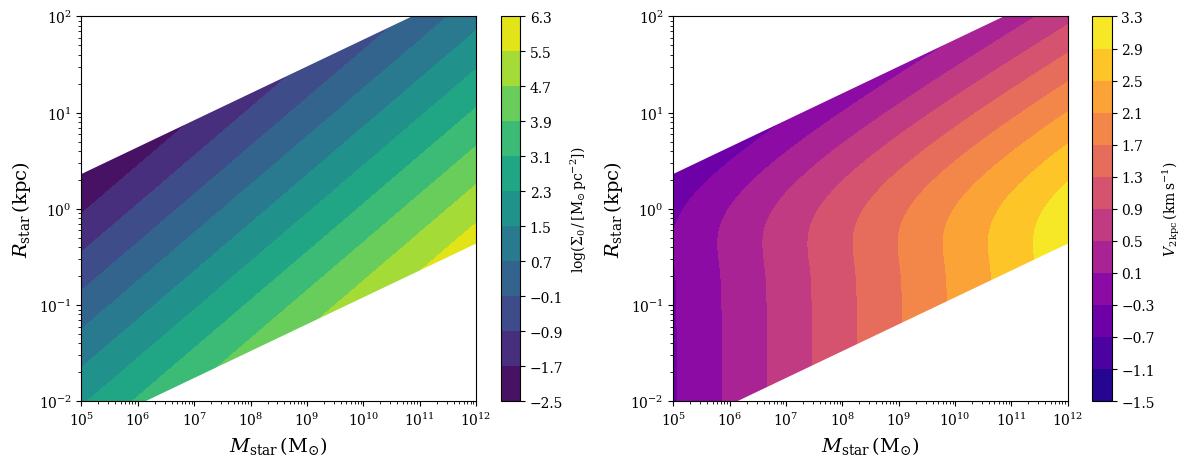

In [887]:
fig,axs = plt.subplots(1,2,figsize = (14,5))
ax1,ax2 = axs
levels = np.arange(-2.5,6.4,.8)
cn = ax1.contourf(mesh_x,mesh_y,mesh_s,cmap = plt.get_cmap('viridis'),levels = levels)
cb = fig.colorbar(cn, ax = ax1,label = 'log$(\Sigma_0\,/\,\mathrm{[M_{\odot}\,pc^{-2}]})$')
cb.set_ticks(levels,minor = False)
levels = np.arange(-1.5,3.5,.4)
cn = ax2.contourf(mesh_x,mesh_y,mesh_2,cmap = plt.get_cmap('plasma'),levels = levels)
cb = fig.colorbar(cn, ax = ax2,label = '$V_{2\,\mathrm{kpc}}\,\mathrm{(km\,s^{-1})}$')
cb.set_ticks(levels,minor = False)
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.scatter(10**np.array(lmstar_bry2),rdstar_bry2)
    # ax.scatter(10**np.array(lmstar_shm),rdstar_shm)
    # ax.scatter(10**np.array(lmstar_bry1),rdstar_bry1)
    ax.fill_between(10**lmstar,10**lrdstar_hig, np.ones(len(lmstar))*1e3, color = 'white')
    ax.fill_between(10**lmstar,10**lrdstar_low, np.ones(len(lmstar))*1e-3, color = 'white')
    # ax.fill_between(10**lmstar,10**lrdstar_hig1, 10**lrdstar_hig, color = 'grey',alpha = 0.5)
    # ax.fill_between(10**lmstar,10**lrdstar_low1, 10**lrdstar_low, color = 'grey',alpha = 0.5)
    ax.set_ylim(1e-2,1e2)
    ax.set_xlabel('$M_{\mathrm{star}}\,(\mathrm{M_{\odot}})$',size = 14)
    ax.set_ylabel('$R_{\mathrm{star}} \, (\mathrm{kpc})$',size = 14)

# plt.savefig('../Output/plots_for_report/Mstar_Rstar_lsig_v2kpc_relations.pdf',bbox_inches = 'tight',dpi = 300)

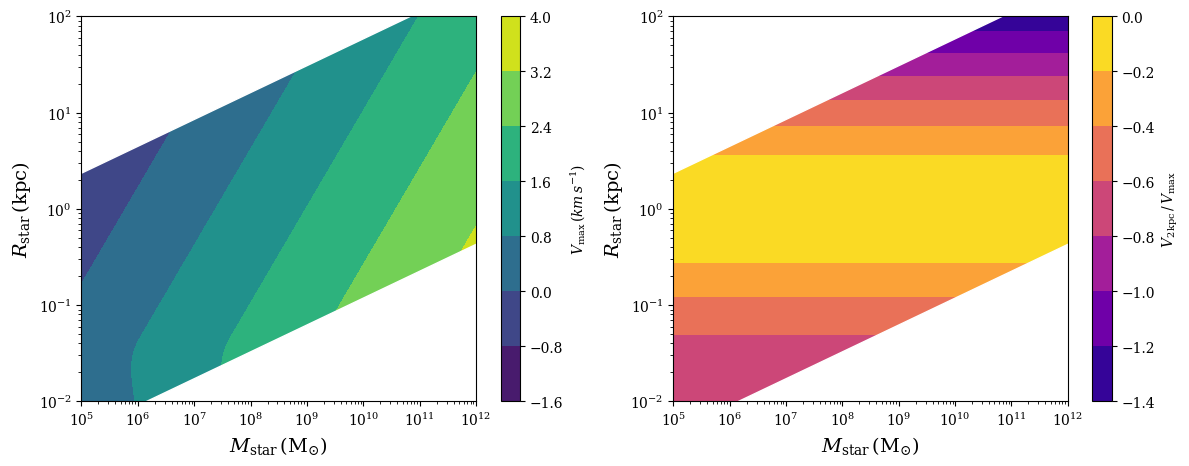

In [908]:
fig,axs = plt.subplots(1,2,figsize = (14,5))
ax1,ax2 = axs
# levels = np.arange(-2.5,6.4,.8)
cn = ax1.contourf(mesh_x,mesh_y,mesh_m,cmap = plt.get_cmap('viridis'))
cb = fig.colorbar(cn, ax = ax1,label = '$V_{\mathrm{max}}\, (km\,s^{-1})$')
# cb.set_ticks(levels,minor = False)
# levels = np.arange(-1.5,3.5,.4)
cn = ax2.contourf(mesh_x,mesh_y,mesh_2-mesh_m,cmap = plt.get_cmap('plasma'))
cb = fig.colorbar(cn, ax = ax2,label = '$V_{2\,\mathrm{kpc}}\,/\,V_{\mathrm{max}}$')
# cb.set_ticks(levels,minor = False)
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.scatter(10**np.array(lmstar_bry2),rdstar_bry2)
    # ax.scatter(10**np.array(lmstar_shm),rdstar_shm)
    # ax.scatter(10**np.array(lmstar_bry1),rdstar_bry1)
    ax.fill_between(10**lmstar,10**lrdstar_hig, np.ones(len(lmstar))*1e3, color = 'white')
    ax.fill_between(10**lmstar,10**lrdstar_low, np.ones(len(lmstar))*1e-3, color = 'white')
    # ax.fill_between(10**lmstar,10**lrdstar_hig1, 10**lrdstar_hig, color = 'grey',alpha = 0.5)
    # ax.fill_between(10**lmstar,10**lrdstar_low1, 10**lrdstar_low, color = 'grey',alpha = 0.5)
    ax.set_ylim(1e-2,1e2)
    ax.set_xlabel('$M_{\mathrm{star}}\,(\mathrm{M_{\odot}})$',size = 14)
    ax.set_ylabel('$R_{\mathrm{star}} \, (\mathrm{kpc})$',size = 14)
    
plt.savefig('../Output/plots_for_report/Mstar_Rstar_Vmax_v2kpc_by_Vmax_relations.pdf',bbox_inches = 'tight',dpi = 300)

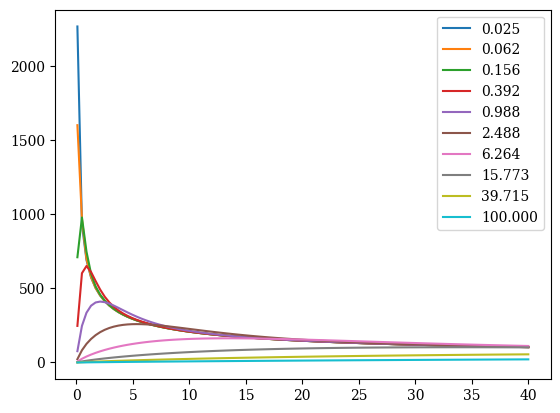

In [906]:
lms = 11
rds = np.logspace(np.log(2*1e-1),2,10)
for rd in rds:
    r = np.linspace(0.1,40,100)
    plt.plot(r,pp.v_exp(lms,rd,r),label = '%.3f'%rd)
plt.legend()
    